In [2]:
# Matematično Nihalo
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import ellipk as K
from scipy.special import ellipj as j
from metode import *
import time

plt.style.use(r'customStyle.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Definiramo diferencialno enačbo
# x''(t) = -b*x'(t) - c*sin(x(t))


def f(y, t, b, c, d, omega):
    x, v = y
    ydt = np.array([v, - b * v - c*np.sin(x) + d*np.cos(omega * x)])
    return ydt


# Analitična rešitev
def analiticna(y0, t, b, c, d, omega):
    x0, v0 = y0
    omega0 = np.sqrt(c)

    sn, cn, dn, _ = j(K((np.sin(x0/2))**2) - omega0 * t, (np.sin(x0/2))**2)

    x = 2 * np.arcsin(np.sin(x0/2) * sn)
    v = 2 * omega0 * np.sin(x0/2) * dn / np.sqrt(1 -
                                                 (np.sin(x0/2) * sn)**2) * cn

    return np.array([x, v])


# Definiramo začetne pogoje
x0 = 1.
v0 = 0.
y0 = np.array([x0, v0])

# Definiramo parametre
b = 0     # Faktor dušenja
c = 1     # Omega_0**2
d = 0         # Amplituda vzbujanja
omega = 1.5    # Frekvenca vzbujanja

In [3]:
# Definiramo časovni vektor
t = np.arange(0, int(1e7), 0.1)
t0 = t
t1 = t[t < 5]
t2 = t[t < 1e3]
t3 = t[t < 5e5]
t4 = t[t < 1e7]
t5 = t[t < 1e6]

In [ ]:
def a(t):
    time0 = time.time()
    real = analiticna(y0, t, b, c, d, omega).T
    time1 = time.time()
    # print(f'analiticna: {time1 - time0} s, {len(t)} steps')
    # np.save('real.npy', real)
    return time1 - time0

In [5]:
def sci(t0):
    time0 = time.time()
    sol0 = odeint(f, y0, t0, args=(b, c, d, omega))
    time1 = time.time()
    # print(f'Scipy: {time1 - time0} s, {len(t0)} steps')
    # np.save('sol0.npy', sol0)
    return time1 - time0

In [6]:
def e(t1):
    time0 = time.time()
    sol1 = euler(f, y0, t1, b, c, d, omega)
    time1 = time.time()
    # print(f'euler: {time1 - time0} s, {len(t1)} steps')
    # np.save('sol1.npy', sol1)
    return time1 - time0

In [7]:
def m(t2):
    time0 = time.time()
    sol2 = mid(f, y0, t2, b, c, d, omega)
    time1 = time.time()
    # print(f'mid: {time1 - time0} s, {len(t2)} steps')
    # np.save('sol2.npy', sol2)
    return time1 - time0

In [8]:
def r(t3):
    time0 = time.time()
    sol3 = rk4(f, y0, t3, b, c, d, omega)
    time1 = time.time()
    # print(f'rk4: {time1 - time0} s, {len(t3)} steps')
    # np.save('sol3.npy', sol3)
    return time1 - time0

In [5]:
real = np.load('real.npy')
sol0 = np.load('sol0.npy')
sol1 = np.load('sol1.npy')
sol2 = np.load('sol2.npy')
sol3 = np.load('sol3.npy')
sol4 = np.load('sol4.npy')
sol5 = np.load('sol5.npy')

In [ ]:
# Narišemo rešitev

plt.plot(t1, sol1[:, 0], label=r'Euler')
plt.plot(t2, sol2[:, 0], label=r'\textit{Midpoint}')
plt.plot(t3, sol3[:, 0], label=r'RK4')
# plt.plot(t0, sol0[:, 0], label=r'\texttt{SciPy}')
plt.plot(t, real[:, 0], label=r'Analitična', c=colors[5])
plt.xlabel(r'$t$')
plt.ylabel(r'${\rm \theta}(t)$')
plt.ylim(-2, 2)
plt.tight_layout()
# plt.show()
plt.close()

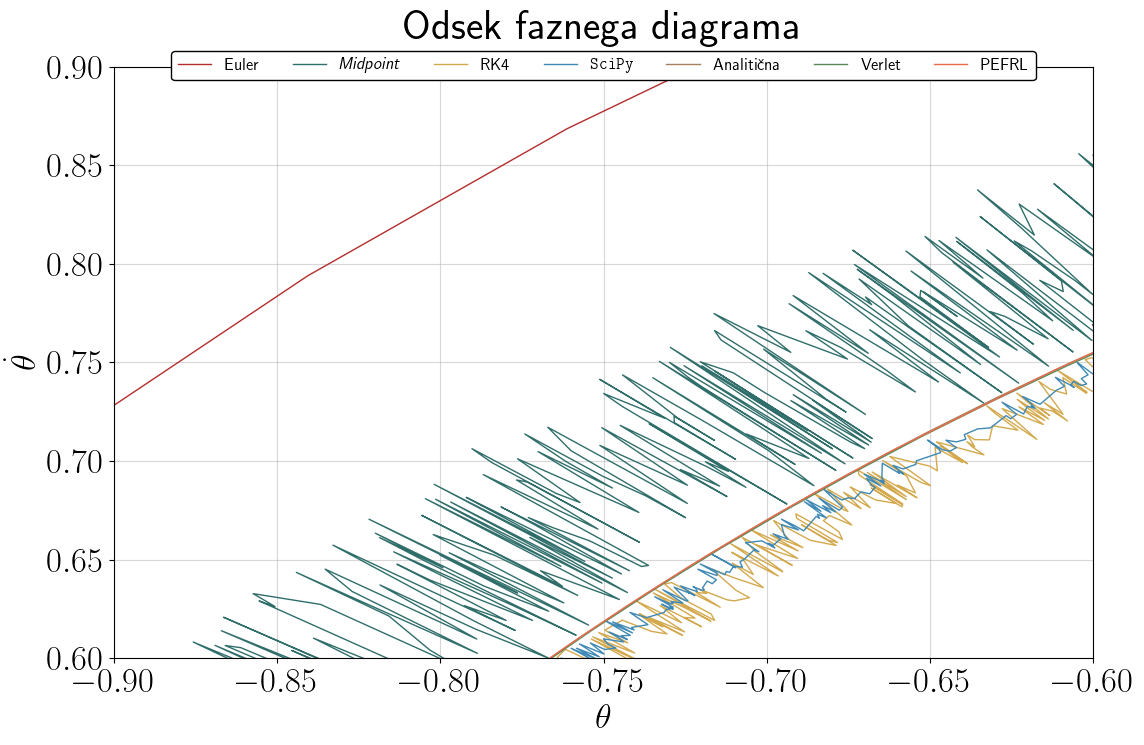

In [ ]:
def smart_reduce_periodic(data, n_points=5000):
    """Reduce points while preserving periodic/elliptical features"""
    if len(data) <= n_points:
        return data
    
    # Convert to polar coordinates for better sampling
    x, y = data[:, 0], data[:, 1]
    x_c, y_c = np.mean(x), np.mean(y)
    r = np.sqrt((x - x_c)**2 + (y - y_c)**2)
    theta = np.arctan2(y - y_c, x - x_c)
    
    # Sort by angle
    sort_idx = np.argsort(theta)
    theta = theta[sort_idx]
    r = r[sort_idx]
    
    # Sample points with density proportional to curvature
    d_theta = np.diff(theta, append=theta[0] - theta[-1])
    d_r = np.diff(r, append=r[0] - r[-1])
    curvature = np.abs(d_r / d_theta)
    
    # Generate indices with variable density
    p = (curvature + 0.1) / np.sum(curvature + 0.1)
    indices = np.random.choice(len(data), size=n_points, p=p, replace=False)
    indices.sort()
    
    return data[sort_idx[indices]]

# Usage in plotting code:
for i, (sol, label) in enumerate(solutions):
    reduced_sol = smart_reduce_periodic(sol)
    plt.plot(reduced_sol[:, 0], reduced_sol[:, 1], 
             label=label, linewidth=1, 
             rasterized=True)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.legend(fontsize=12, loc='upper center', 
          bbox_to_anchor=(0.5, 1.04), 
          ncol=7, framealpha=1, 
          edgecolor='black')
plt.title(r'Odsek faznega diagrama', pad=20)
plt.xlim(-0.9, -0.6)
plt.ylim(0.6, 0.9)
plt.tight_layout()
# plt.savefig('fazni_diagram_cut.pdf')
plt.show()
plt.close()

Here


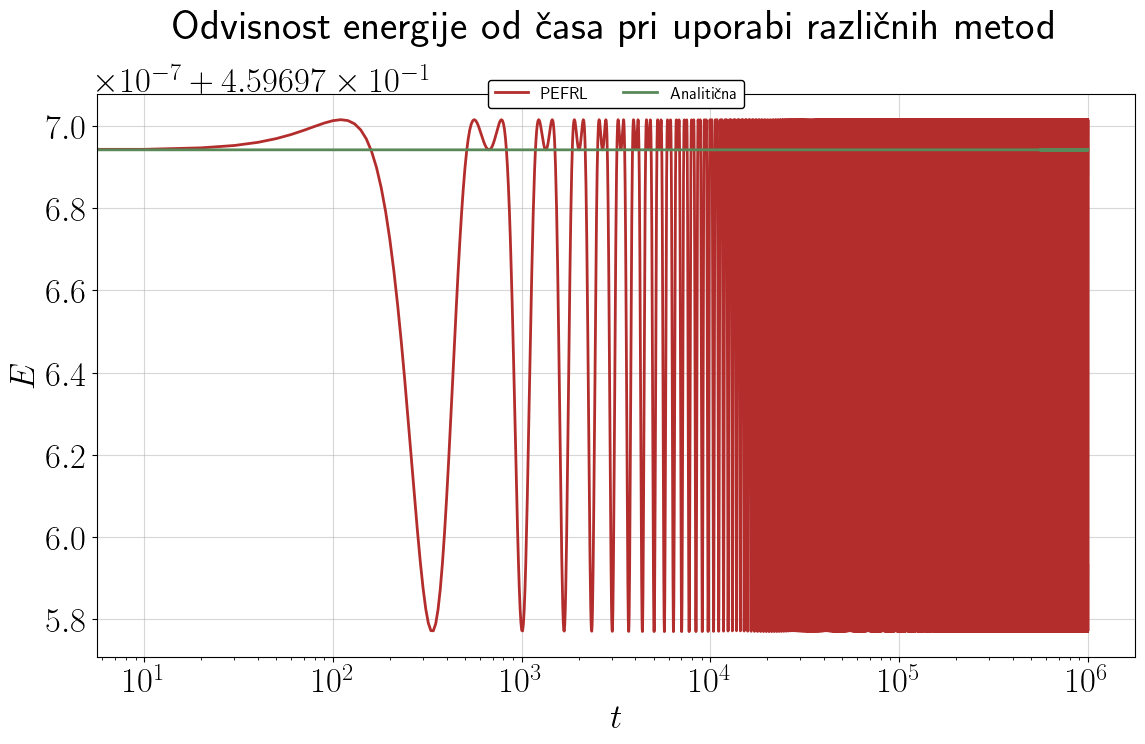

In [ ]:
# Narišemo energijo

# E0 = 1 - np.cos(sol0[:, 0]) + 0.5/c * sol0[:, 1]**2
# E1 = 1 - np.cos(sol1[:, 0]) + 0.5/c * sol1[:, 1]**2
# E2 = 1 - np.cos(sol2[:, 0]) + 0.5/c * sol2[:, 1]**2
# E3 = 1 - np.cos(sol3[:, 0]) + 0.5/c * sol3[:, 1]**2
E4 = 1 - np.cos(sol4[:, 0]) + 0.5/c * sol4[:, 1]**2
E5 = 1 - np.cos(sol5[:, 0]) + 0.5/c * sol5[:, 1]**2

E = 1 - np.cos(real[:, 0]) + 0.5/c * real[:, 1]**2

print('Here')
# plt.plot(t1, E1, label=r'Euler')
# plt.plot(t2, E2, label=r'\textit{Midpoint}')
# plt.plot(t3, E3, label=r'RK4')
# plt.plot(t0, E0, label=r'\texttt{SciPy}')
# plt.plot(t4[::100], E4[::100], label=r'Verlet')
plt.plot(t5[::100], E5[::100], label=r'PEFRL')
plt.plot(t[:len(E5):100], E[:len(E5):100], label=r'Analitična', c=colors[5])
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(
    0.5, 1.04), ncol=6, framealpha=1, edgecolor='black')
# plt.ylim(0.45, 1e0)
plt.xscale('log')
plt.title('Odvisnost energije od časa pri uporabi različnih metod', pad=20)
# plt.savefig('energija.pdf')
# plt.savefig('pefrl.pdf')
plt.tight_layout()
plt.show()
plt.close()


In [10]:
def v(t4):
    time0 = time.time()
    sol4 = verlet(f, y0, t4, b, c, d, omega)
    time1 = time.time()
    # print(f'Verlet: {time1 - time0} s, {len(t4)} steps')
    # np.save('sol4.npy', sol4)
    return time1 - time0

In [11]:
def p(t5):
    time0 = time.time()
    sol5 = pefrl(f, y0, t5, b, c, d, omega)
    time1 = time.time()
    # print(f'PEFRL: {time1 - time0} s, {len(t4)} steps')
    # np.save('sol5.npy', sol5)
    return time1 - time0

In [ ]:

def measure_execution_times(functions, time_arrays, min_samples=5):
    """Measure execution time for multiple functions with increasing array sizes
    
    Args:
        functions: List of functions to test
        time_arrays: List of time arrays for each function
        min_samples: Minimum number of measurements per function
    """
    measured_times = [[] for _ in functions]
    
    for i, (func, t) in enumerate(zip(functions, time_arrays)):
        # Initialize sizes to test
        sizes = np.logspace(1, np.log10(len(t)), min_samples, dtype=int)
        print(sizes)
        # Warm up
        _ = func(t[:10])
        
        # Measure times
        for size in sizes:
            try:
                measured_times[i].append(func(t[:size]))
            except Exception as e:
                print(f"Error in function {i} at size {size}: {e}")
                break
                
    return measured_times

# Usage
functions = [a, sci, e, m, r, v, p] 
time_arrays = [t, t0, t1, t2, t3, t4, t5]
times = measure_execution_times(functions, time_arrays)
np.save('measured_times.npy', times)

[       10       562     31622   1778279 100000000]


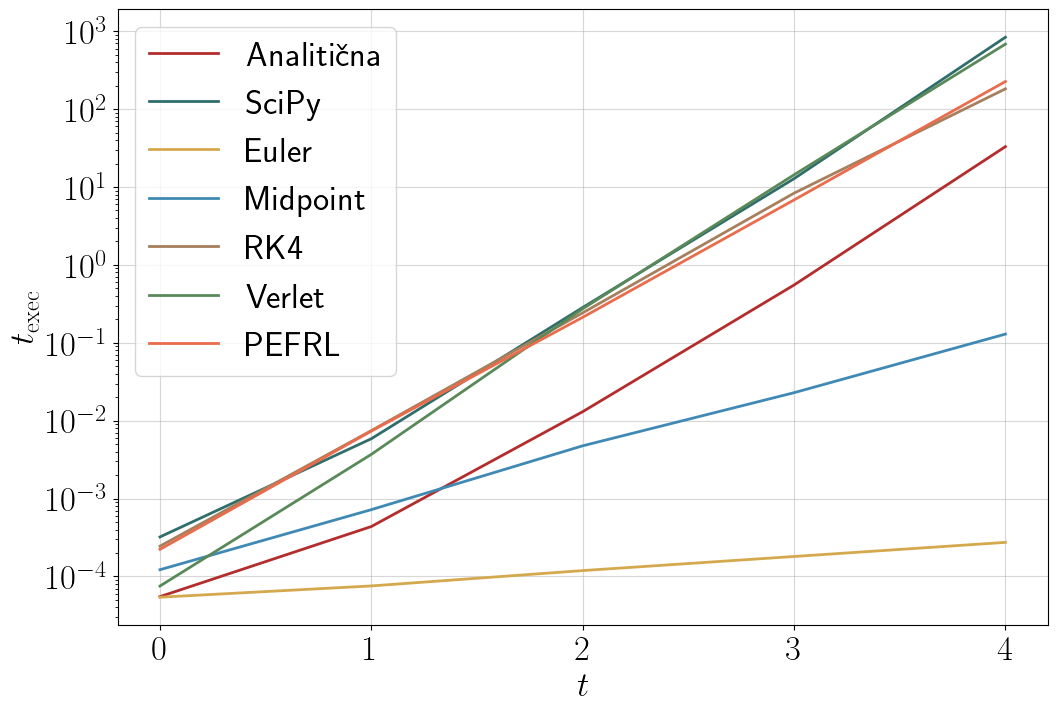

In [13]:
mtimes = np.load('measured_times.npy')
plt.plot(mtimes[0], label='Analitična')
plt.plot(mtimes[1], label='SciPy')
plt.plot(mtimes[2], label='Euler')
plt.plot(mtimes[3], label='Midpoint')
plt.plot(mtimes[4], label='RK4')
plt.plot(mtimes[5], label='Verlet')
plt.plot(mtimes[6], label='PEFRL')
plt.xlabel(r'$t$')
plt.ylabel(r'$t_{\rm exec}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')

plt.show()
plt.close()
